## RQ2. How frequent are, and what are the main characteristics of long-lived bugs in FLOSS projects?

## Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| OSS Project                |        Eclipse       |
| Number of Bug Reports      |        8438          |
| Threshold (in days)        |          365         |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup experimental environment.

In [2]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import pandas as pd
import seaborn as sns 
import string

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup matplotlib and seaborn
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
%matplotlib inline 

sns.set_context("paper")

# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
bug_reports_path = 'datasets/20190830_eclipse_bug_report_data.csv'
bug_reports_history_path = 'datasets/20190830_eclipse_bug_report_history_data.csv'

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

[nltk_data] Downloading package punkt to /home/luiz/nltk_data...


Setup complete


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/luiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2. Load data.

In [3]:

!echo "Header of bug reports file"
!head -n 2 $bug_reports_path

!echo "\nNumber of lines in the file:"
!wc -l $bug_reports_path


Header of bug reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of detached objects,"Cloned from: 354395: containsAll returns wrong result in case of detached objects

Number of lines in the file:
387100 datasets/20190830_eclipse_bug_report_data.csv


In [4]:
bug_reports_data = pd.read_csv(bug_reports_path)
rows_and_cols = bug_reports_data.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

print(bug_reports_data.info())

There are 24364 rows and 19 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24364 entries, 0 to 24363
Data columns (total 19 columns):
bug_id                  24364 non-null object
creation_date           24364 non-null object
component_name          24364 non-null object
product_name            24364 non-null object
short_description       24361 non-null object
long_description        24002 non-null object
assignee_name           24364 non-null object
reporter_name           24364 non-null object
resolution_category     24364 non-null object
resolution_code         24364 non-null int64
status_category         24364 non-null object
status_code             24364 non-null int64
update_date             24364 non-null object
quantity_of_votes       24364 non-null int64
quantity_of_comments    24364 non-null int64
resolution_date         24364 non-null object
bug_fix_time            24364 non-null int64
severity_category       24364 non-null object
severity_code           24364 

In [5]:
!echo "Header of bug reports history file"
!head -n 2 $bug_reports_history_path

!echo "\nNumber of lines in the history file:"
!wc -l $bug_reports_history_path


Header of bug reports history file
Key,Who,When,What,Removed,Added
EMF-354412,stepper,2011-08-10,status,new,assigned

Number of lines in the history file:
192050 datasets/20190830_eclipse_bug_report_history_data.csv


In [6]:
bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
rows_and_cols = bug_reports_history_data.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

print(bug_reports_history_data.info())

There are 192049 rows and 6 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192049 entries, 0 to 192048
Data columns (total 6 columns):
Key        192049 non-null object
Who        192049 non-null object
When       192049 non-null object
What       192049 non-null object
Removed    146419 non-null object
Added      190443 non-null object
dtypes: object(6)
memory usage: 8.8+ MB
None


## Step 3. Review the data

In [7]:
bug_reports_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,closed,6,2012-09-21,0,5,2011-08-10,0,normal,2
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,resolved,4,2010-03-03,0,6,2009-04-29,177,normal,2
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,resolved,4,2011-03-02,0,5,2011-03-02,1,normal,2
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,resolved,4,2010-03-24,0,7,2006-08-29,50,major,4
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,resolved,4,2013-04-02,0,3,2013-04-02,264,critical,5


In [8]:
bug_reports_history_data.head()

,Key,Who,When,What,Removed,Added
0,EMF-354412,stepper,2011-08-10,status,new,assigned
1,EMF-354412,stepper,2011-08-10,assignee,emf.cdo-inbox,stepper
2,EMF-354412,stepper,2011-08-10,status,assigned,resolved
3,EMF-354412,stepper,2011-08-10,resolution,---,fixed
4,EMF-354412,stepper,2012-09-21,status,resolved,closed


## Step 4. Pre-processing the data

In [9]:
bug_reports_data['resolution_code'] = bug_reports_data['resolution_code'].astype('category')
bug_reports_data['status_category'] = bug_reports_data['status_category'].astype('category')
bug_reports_data['severity_code']   = bug_reports_data['severity_code'].astype('category')
bug_reports_data['short_description'] = bug_reports_data['short_description'].fillna("")
bug_reports_data['long_description'] = bug_reports_data['long_description'].fillna("")
bug_reports_data['short_description_length'] = bug_reports_data['short_description'].str.split().apply(lambda l: len(l))
bug_reports_data['long_description_length']  = bug_reports_data['long_description'].str.split().apply(lambda l: len(l))
bug_reports_data['short_description_length'] = bug_reports_data['short_description_length'].fillna(0)
bug_reports_data['long_description_length'] = bug_reports_data['long_description_length']
bug_reports_data['long_lived?']  = bug_reports_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')
bug_reports_data['long_lived?']  = bug_reports_data['long_lived?'].astype('category')
bug_reports_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,short_description_length,long_description_length,long_lived?
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,...,2012-09-21,0,5,2011-08-10,0,normal,2,9,134,short-lived
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,...,2010-03-03,0,6,2009-04-29,177,normal,2,8,179,short-lived
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,...,2011-03-02,0,5,2011-03-02,1,normal,2,7,23,short-lived
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,...,2010-03-24,0,7,2006-08-29,50,major,4,7,29,short-lived
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,...,2013-04-02,0,3,2013-04-02,264,critical,5,14,73,short-lived


## Step 5. How frequent are long-lived bugs?

[None]

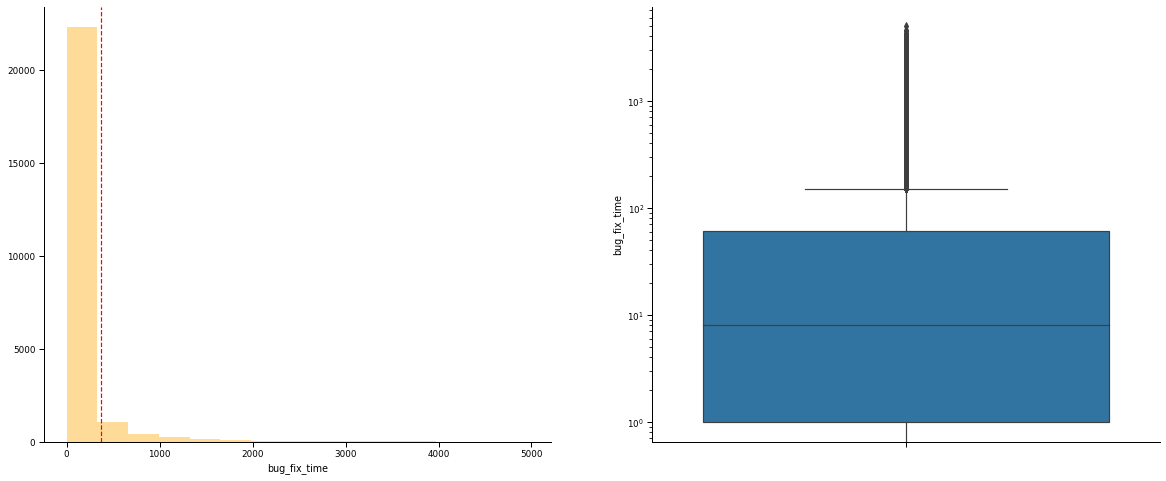

In [10]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
sns.despine()
g = sns.distplot(bug_reports_data['bug_fix_time'], kde=False, bins=15, hist=True, color="orange", ax=ax[0])
g.axvline(bug_fix_time_threshold, color='r', linestyle='--', label = "Threshold : {}".format(bug_fix_time_threshold))
g = sns.boxplot(y="bug_fix_time", data=bug_reports_data, showfliers=True, ax=ax[1])
g.set(yscale="log")

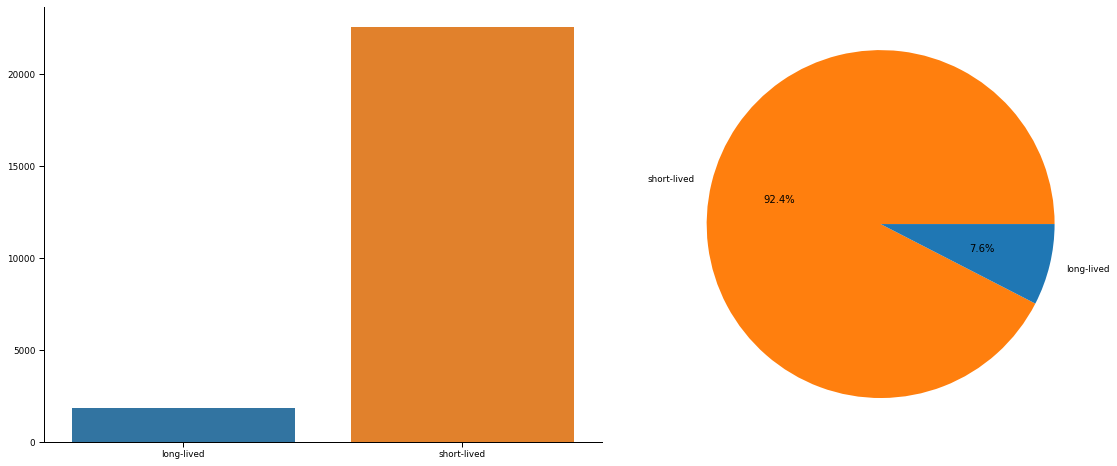

In [11]:
bug_reports_count = bug_reports_data["long_lived?"].value_counts()

f, axes = plt.subplots(figsize=(20,8), ncols=2)
sns.despine()

sns.barplot(x=bug_reports_count.index, y=bug_reports_count.values, palette=[ "tab:blue", "tab:orange"], ax=axes[0])
axes[1].pie(bug_reports_count.values, labels=bug_reports_count.index, autopct='%1.1f%%', colors=["tab:orange", "tab:blue"])

plt.subplots_adjust(wspace=0, hspace=1)

## Step 6. Bug Reporter

In [12]:
number_of_reports   = bug_reports_data['bug_id'].count()
number_of_reporters = bug_reports_data['reporter_name'].nunique()
print("%s reporters reported %s bugs." % (number_of_reporters, number_of_reports))

4977 reporters reported 24364 bugs.


In [13]:
top_10_reporters = bug_reports_data.groupby('reporter_name').reporter_name.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

,count
reporter_name,
david_williams,323
eclipse,252
markus.kell.r,221
wayne.beaton,220
john.arthorne,201
ed,171
Lars.Vogel,168
pascal,166
daniel_megert,157


[None]

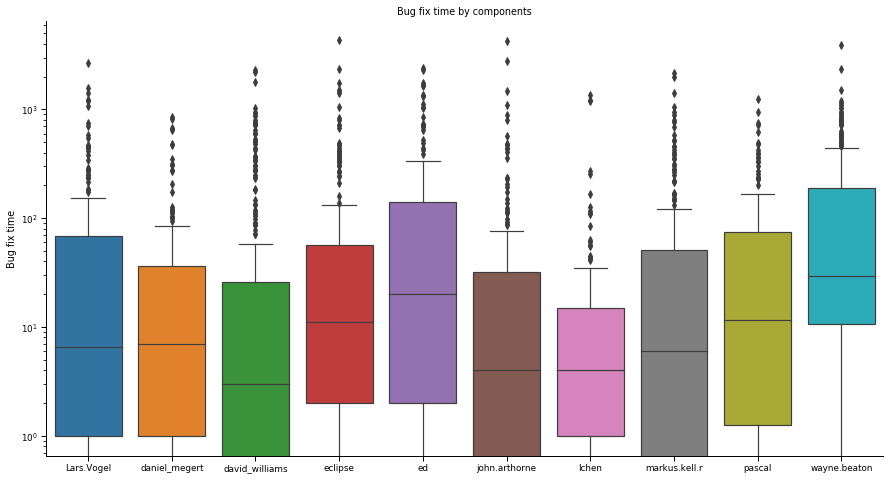

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
sns.despine()
bug_reports_data_for_top_10_reporters=bug_reports_data[bug_reports_data['reporter_name'].isin(top_10_reporters.index)]
bug_reports_data_for_top_10_reporters=bug_reports_data_for_top_10_reporters.sort_values(by=['reporter_name'])
g = sns.boxplot(data=bug_reports_data_for_top_10_reporters
            , x="reporter_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by reporter')]

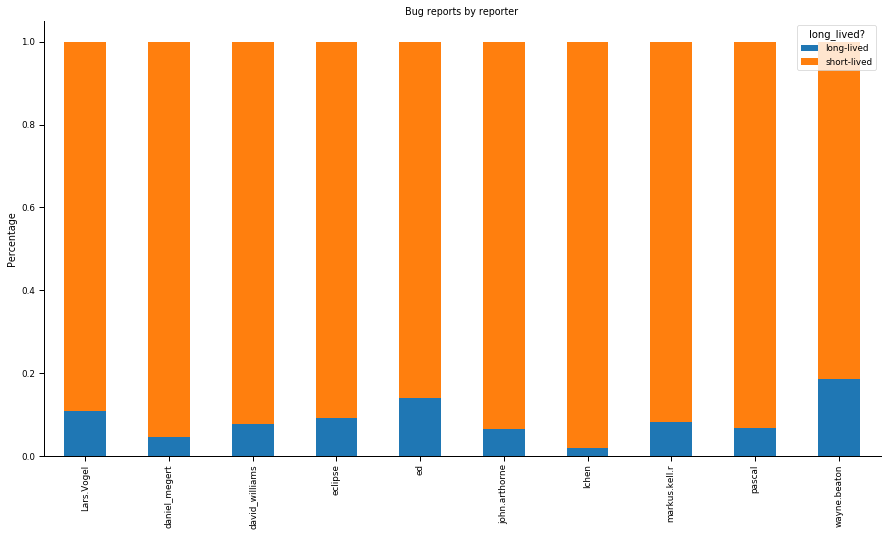

In [15]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_reporters.groupby("reporter_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by reporter", xlabel="", ylabel="Percentage")


## Step 7. Assignee

In [16]:
top_10_assignee = bug_reports_data.groupby('assignee_name').assignee_name.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:9]
top_10_assignee

,count
assignee_name,
webmaster,526
rap-inbox,272
tmf.xtext-inbox,251
Silenio_Quarti,221
emo,197
david_williams,188
mdt-papyrus-inbox,183
eclipse,182
pde-ui-inbox,170


[None]

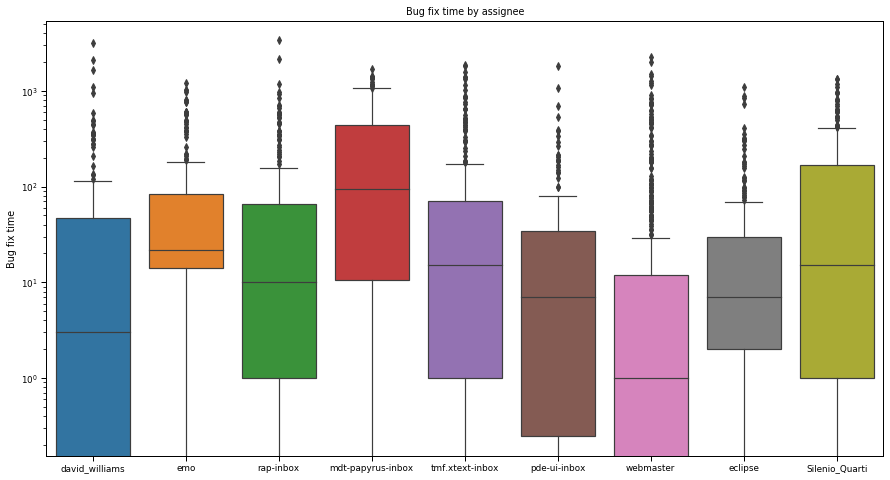

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_assignee=bug_reports_data[bug_reports_data['assignee_name'].isin(top_10_assignee.index)] 
g = sns.boxplot(data=bug_reports_data_for_top_10_assignee
            , x="assignee_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by assignee", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by assignee')]

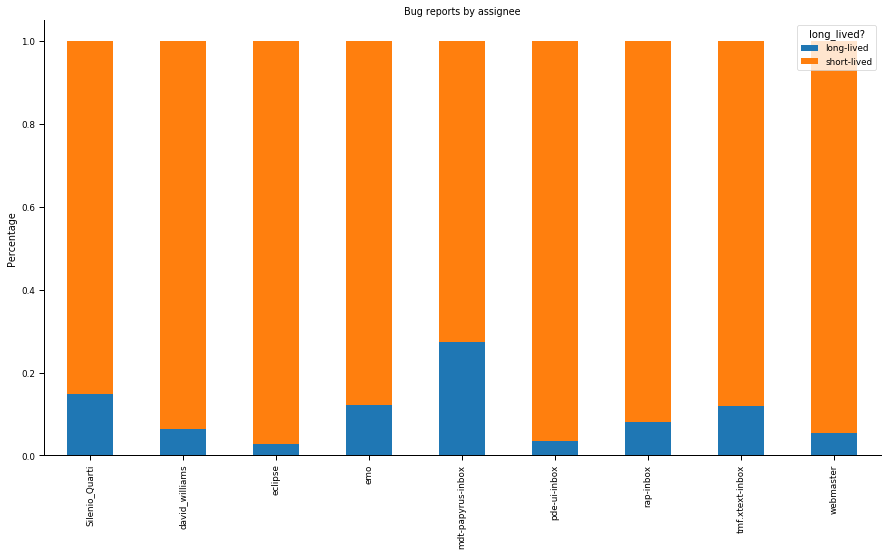

In [18]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_assignee.groupby("assignee_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by assignee", xlabel="", ylabel="Percentage")

## Step 8. Component

In [19]:
top_10_component = bug_reports_data.groupby('component_name').component_name.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

,count
component_name,
UI,2676
Core,1949
SWT,882
TPTP,699
General,498
Releng,449
Client,385
cdt-core,335
Hyades,312


[None]

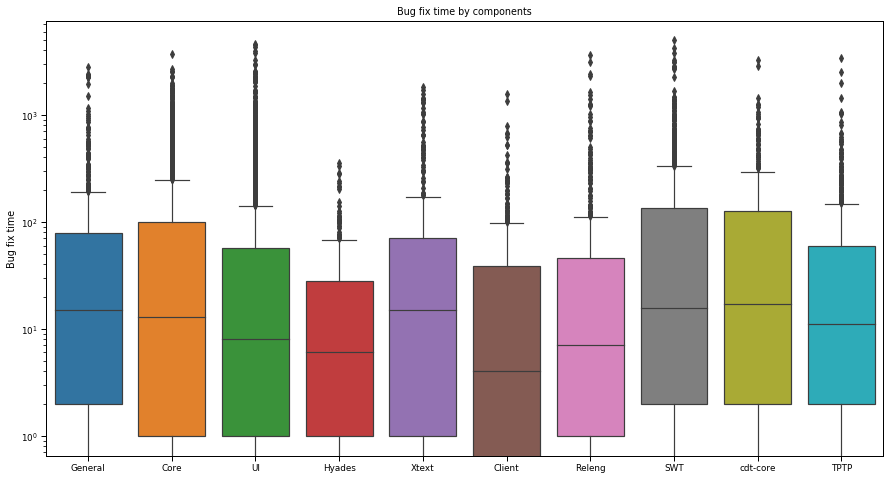

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_component=bug_reports_data[bug_reports_data['component_name'].isin(top_10_component.index)] 
g = sns.boxplot(data=bug_reports_data_for_top_10_component
            , x="component_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by components')]

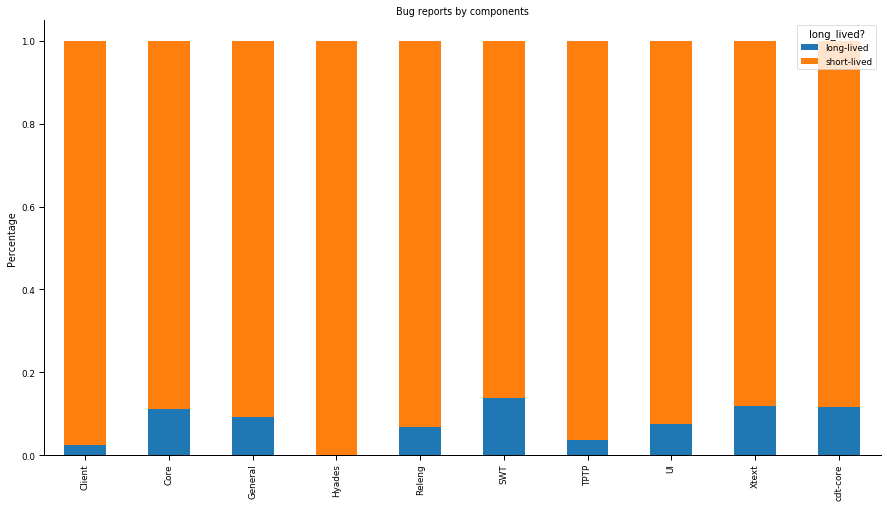

In [21]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_component.groupby("component_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by components", xlabel="", ylabel="Percentage")

## Step 9. Analysis of Short and Long Descrption

### How is the distribution of number of words

[Text(0, 0.5, 'Number of words'),
 Text(0.5, 0, ' '),
 Text(0.5, 1.0, 'Distribution of number of words in short description')]

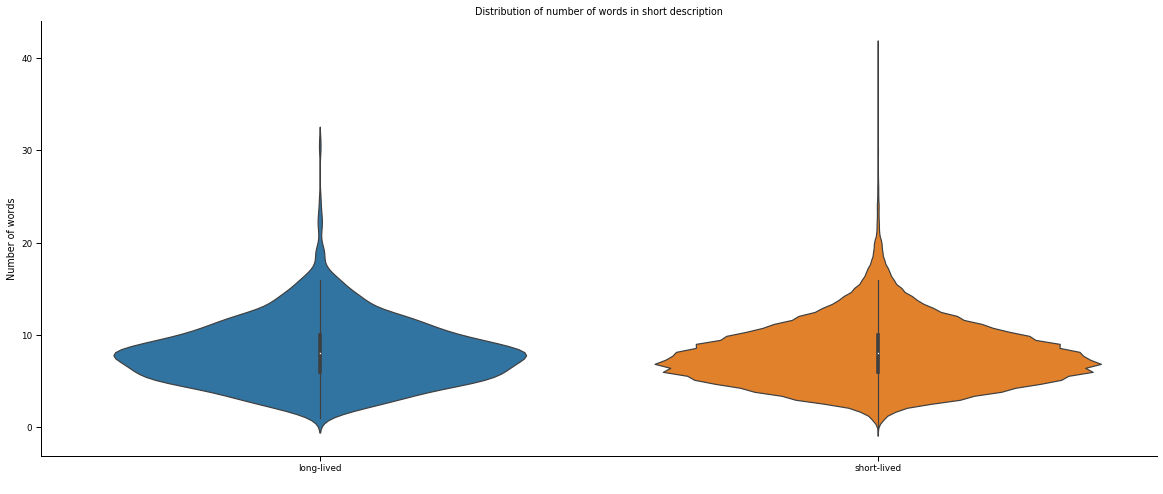

In [22]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

g = sns.violinplot(x="long_lived?", y="short_description_length", data=bug_reports_data)
#g = sns.boxplot(x="long_lived?", y="short_description_length", data=bug_reports_data, showfliers=True)
g.set(title="Distribution of number of words in short description", ylabel="Number of words", xlabel=" ")
#g.set(yscale="log")

[None]

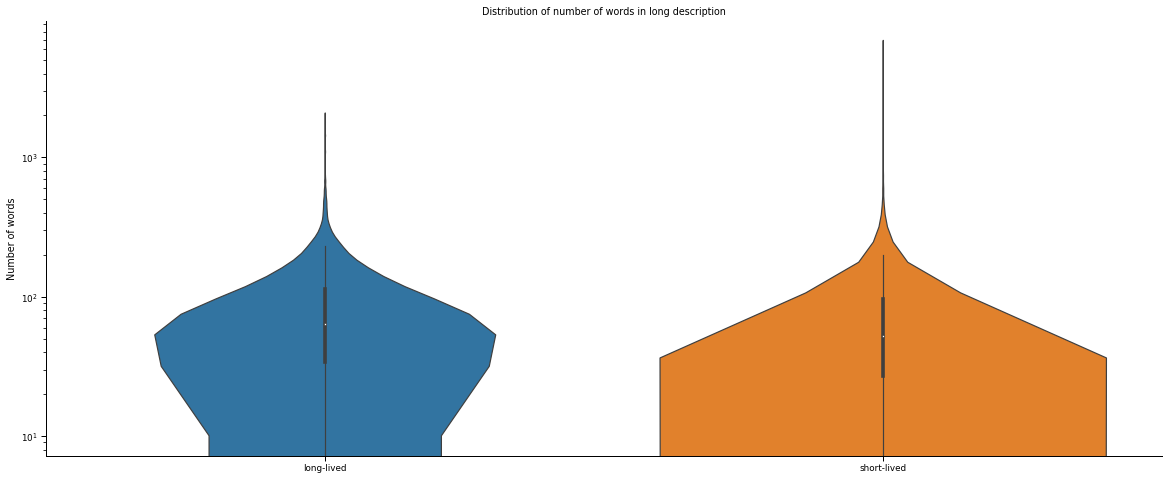

In [23]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

g = sns.violinplot(x="long_lived?", y="long_description_length", data=bug_reports_data)
#g = sns.boxplot(x="long_lived?", y="long_description_length", data=bug_reports_data, showfliers=True)
g.set(title="Distribution of number of words in long description", ylabel="Number of words", xlabel=" ")
g.set(yscale="log")

### Short Description Word cloud

In [24]:
def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    else:
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title)
    axe.axis("off")

def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
        
    return "".join(stem_sentence)

def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['eclipse', 'org', 'xml', 'java', 'project', 'view', 'editor', 'file', 'test', 'update', 'will'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, 'Word Cloud for {} [Short-Lived Bugs]'.format(title), ax[0])
    plot_one_word_cloud(ll_text, 'Word Cloud for {} [Long-Lived Bugs]'.format(title), ax[1])


    

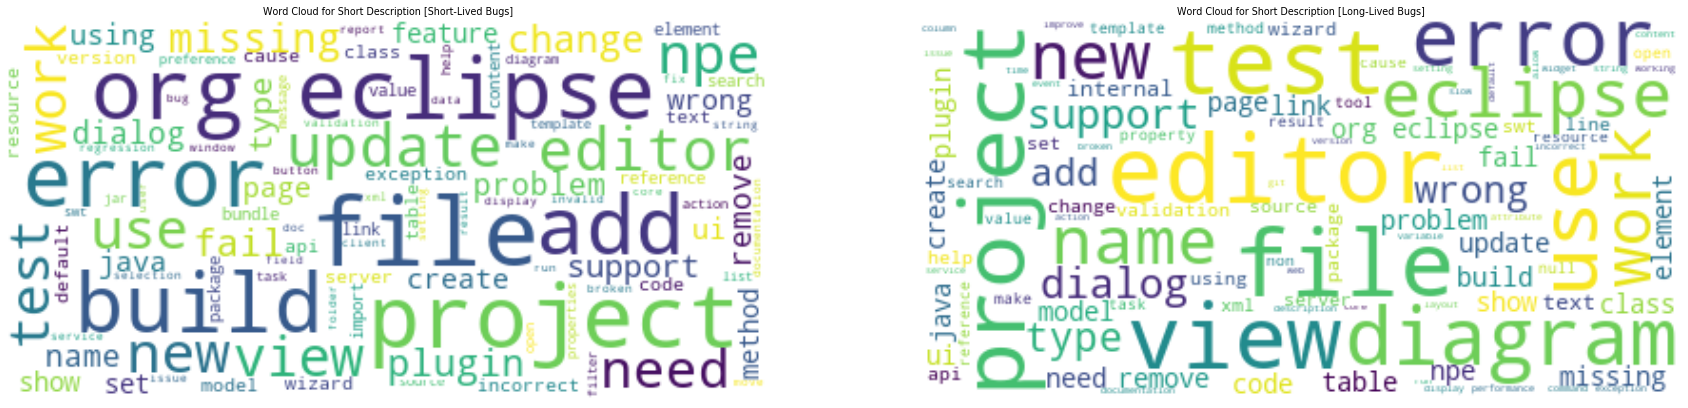

In [25]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description')

### Short Description Word cloud with Text Mining

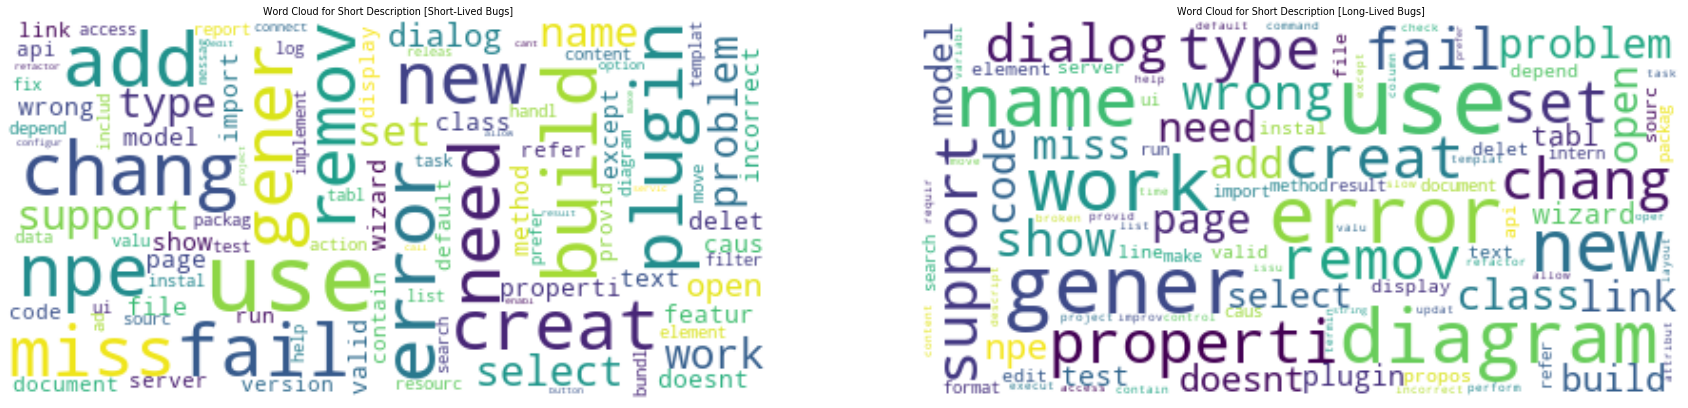

In [26]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description', True)

### Long Description Word cloud

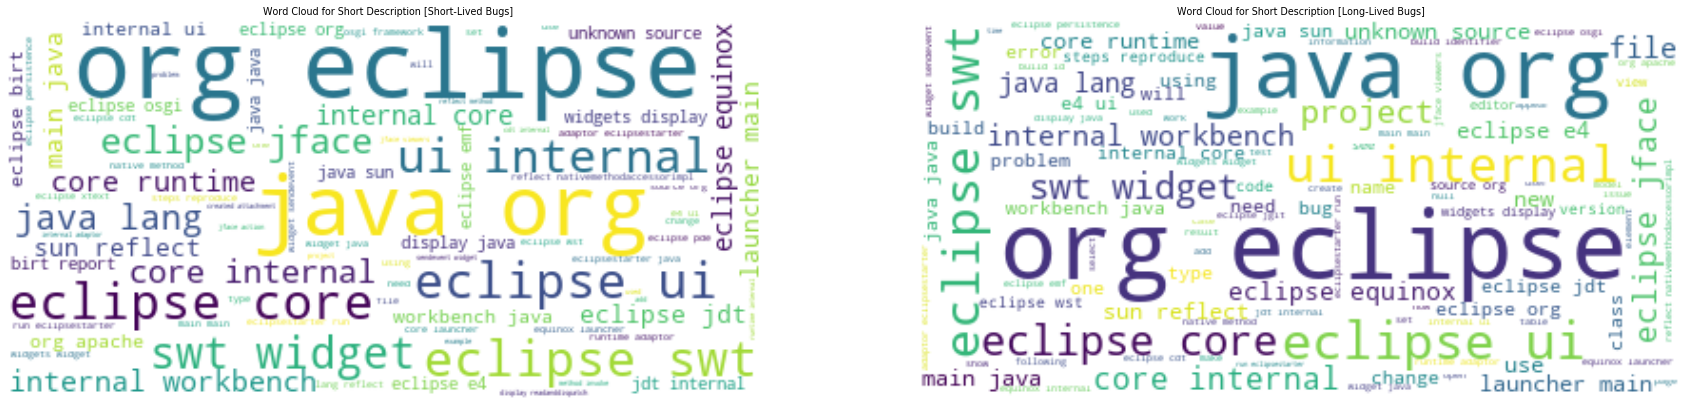

In [27]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Short Description', False)

### Long Description Word cloud with Text Mining

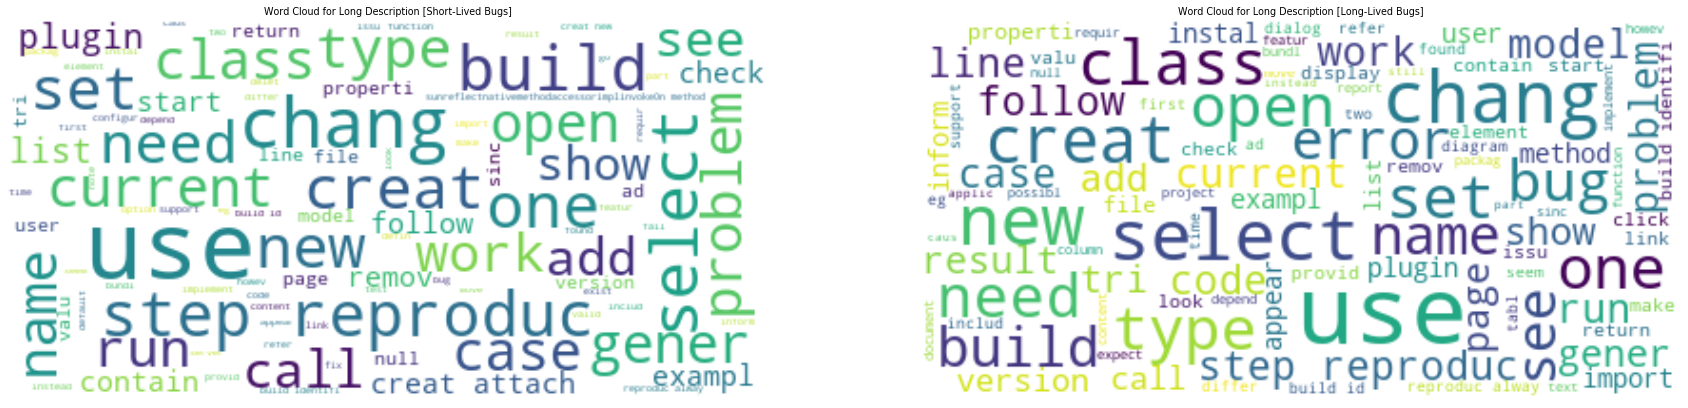

In [28]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Long Description', True)

## Step 10. Analysis of Severity Level

### Severity level distribution

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of severity level')]

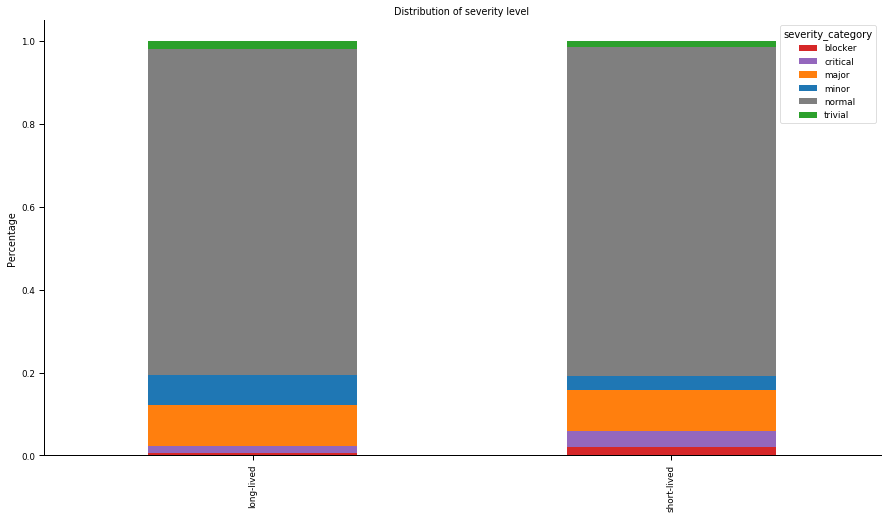

In [29]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
severity_palette=color=["tab:red", "tab:purple", "tab:orange", "tab:blue", "tab:gray", "tab:green"]
bug_reports_data_grouped = bug_reports_data.groupby("long_lived?")['severity_category'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=axes)

axes.set(title="Distribution of severity level", xlabel="", ylabel="Percentage")


[None]

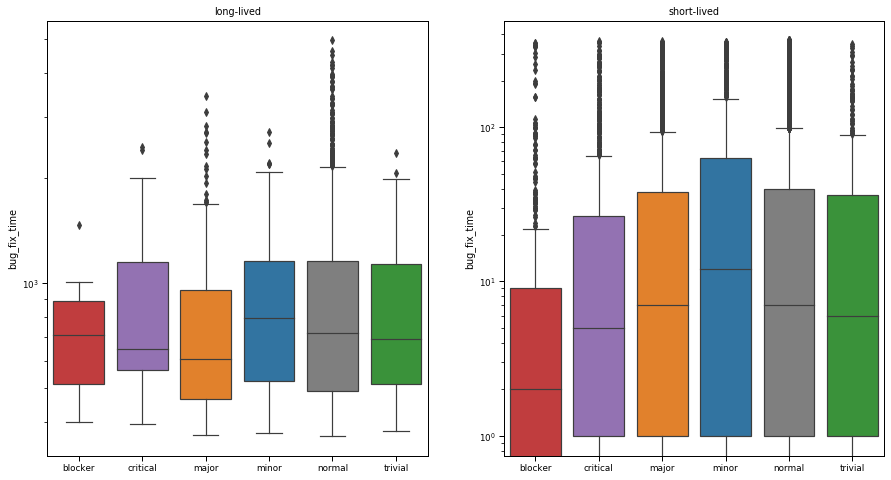

In [30]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2)

g1 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='long-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[0])
g1.set(title="long-lived", xlabel="")
g1.set(yscale="log")

g2 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='short-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[1])
g2.set(title="short-lived", xlabel="")
g2.set(yscale="log")


### Number of Changes

/home/luiz/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/luiz/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


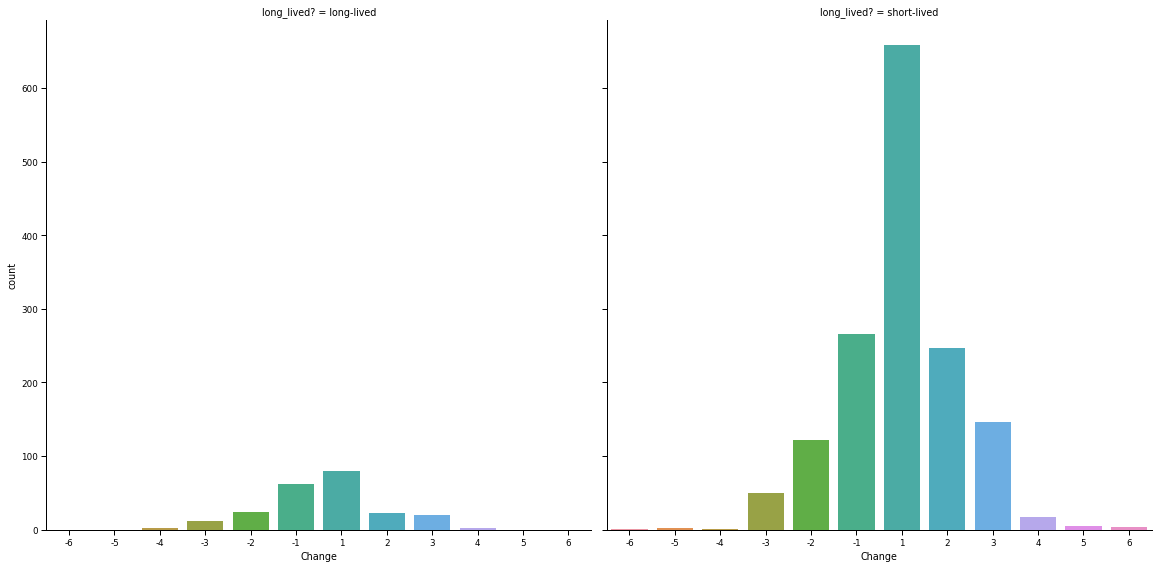

In [31]:
severity_levels = {'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6, 'enhancement':0}
bug_reports_history_merged = pd.merge(
    bug_reports_history_data,
    bug_reports_data[['bug_id', 'creation_date', 'update_date', 'resolution_date', 'bug_fix_time', 'long_lived?']],
    left_on='Key',
    right_on='bug_id',
    how='left'
)
    
severity_changes_data = bug_reports_history_merged[(bug_reports_history_merged['What'] == 'severity')]
severity_changes_data.loc[:, 'Removed'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Removed']]
severity_changes_data.loc[:, 'Added'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Added']]
severity_changes_data['Change'] = severity_changes_data['Added'] - severity_changes_data['Removed']

sns.catplot(x="Change", col="long_lived?",data=severity_changes_data, kind="count",height=8, aspect=1);



In [78]:
bug_reports_history_data.dropna(inplace=True)
assignee_history_data = bug_reports_history_data[(bug_reports_history_data['What'] == 'assignee') & (bug_reports_history_data['Removed'].str.contains("inbox"))]

assignee_history_data_merged = pd.merge(
    assignee_history_data,
    bug_reports_data[['bug_id', 'creation_date', 'update_date', 'resolution_date', 'bug_fix_time', 'long_lived?']],
    left_on='Key',
    right_on='bug_id',
    how='left'
)

assignee_history_data_merged["bug_assignee_time"] = (pd.to_datetime(assignee_history_data_merged["When"]) - pd.to_datetime(assignee_history_data_merged["creation_date"])).dt.days 

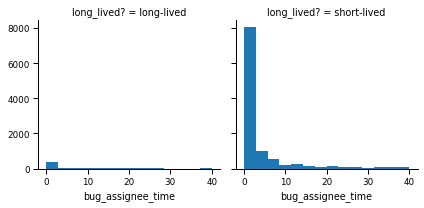

In [84]:
assignee_history_data_merged.dropna(inplace=True)
grid = sns.FacetGrid(assignee_history_data_merged, col="long_lived?", margin_titles=True)
grid.map(plt.hist, "bug_assignee_time", bins=np.linspace(0, 40, 15));

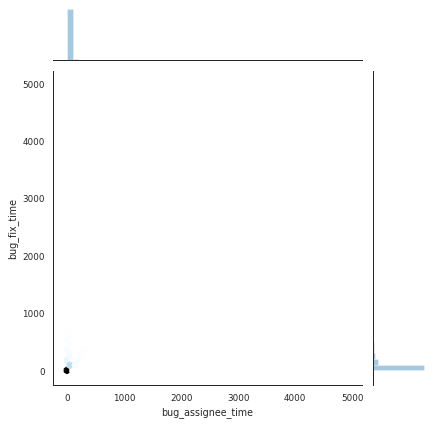

In [82]:
with sns.axes_style('white'):
    g = sns.jointplot("bug_assignee_time", "bug_fix_time", assignee_history_data_merged, kind='hex');